In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## For visualizing results
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
def filterDataset(ann_path, classes):    
    # initialize COCO api for instance annotations
    annFile = ann_path
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [4]:
train_ann_path = r'D:\Nirwan\MRCNN_TF2\Mask-RCNN-TF2\ishape_dataset\log\train\coco_format\instances_train2017.json'
val_ann_path = r'D:\Nirwan\MRCNN_TF2\Mask-RCNN-TF2\ishape_dataset\log\val\coco_format\instances_train2017.json'

In [5]:
coco = COCO(train_ann_path)

loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


In [6]:
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

nms=[cat['name'] for cat in cats]
print(len(nms),'COCO categories: \n{}\n'.format(', '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print(len(nms),'COCO supercategories: \n{}'.format(' '.join(nms)))

1 COCO categories: 
cat1

1 COCO supercategories: 
supercat1


In [7]:
classes = ['cat1']

In [8]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
    
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask


def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mask_type='binary'):
    
    img_folder = '{}'.format(folder)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            #print(imageObj)
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        
        assert not np.any(np.isnan(img))
        assert not np.any(np.isnan(mask))
        
        yield img, mask

In [9]:
train_images, train_dataset_size, train_coco = filterDataset(train_ann_path, classes,)
val_images, val_dataset_size, val_coco = filterDataset(val_ann_path, classes,)

loading annotations into memory...
Done (t=1.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [10]:
batch_size = 4
input_image_size = (256,256)
mask_type = 'normal'

train_img_folder = r'D:\Nirwan\MRCNN_TF2\Mask-RCNN-TF2\ishape_dataset\log\train\coco_format\train2017'
val_img_folder = r'D:\Nirwan\MRCNN_TF2\Mask-RCNN-TF2\ishape_dataset\log\val\coco_format\train2017'

train_gen = dataGeneratorCoco(train_images, classes, train_coco, train_img_folder,
                            input_image_size, batch_size, mask_type)
val_gen = dataGeneratorCoco(val_images, classes, val_coco, val_img_folder,
                            input_image_size, batch_size, mask_type)

In [11]:
def visualizeGenerator(gen):
    img, mask = next(gen)
    
    return img[0], mask[0]    

In [12]:
img, mask = visualizeGenerator(train_gen)


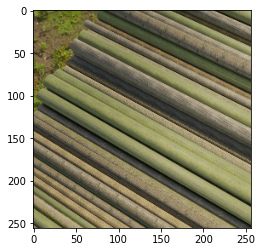

In [13]:
plt.imshow(img)

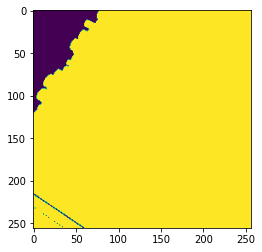

In [14]:
plt.imshow(mask)

In [15]:
n_epochs = 20
steps_per_epoch = train_dataset_size // batch_size
validation_steps = val_dataset_size // batch_size

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
import segmentation_models as sm
from tensorflow import keras

Segmentation Models: using `keras` framework.


In [18]:
model = sm.Unet('efficientnetb7', classes=1, activation='sigmoid')

In [19]:
optim = keras.optimizers.Adam(0.0001)

In [20]:
dice_loss = sm.losses.DiceLoss(class_weights=np.ones(1)) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [21]:
model.compile(optim, total_loss, metrics)

In [22]:
checkpoint_dir = './training_checkpoints/log'
        # Define the name of the checkpoint files.
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [23]:
callbacks = [
        tf.keras.callbacks.TensorBoard(log_dir='./semantic_logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, verbose=0,
                                            save_weights_only=True),
        tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                            min_delta=0.001,
                                            patience=3,
                                            verbose=1,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True),
    ]

In [24]:
history = model.fit(x=train_gen, validation_data=val_gen, epochs=20, steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps, verbose=True, callbacks=callbacks)

Epoch 1/20
500/500 [==============================] - 604s 1s/step - loss: 0.1000 - iou_score: 0.9362 - f1-score: 0.9658 - val_loss: 0.0398 - val_iou_score: 0.9850 - val_f1-score: 0.9924
Epoch 2/20
500/500 [==============================] - 548s 1s/step - loss: 0.0327 - iou_score: 0.9785 - f1-score: 0.9889 - val_loss: 0.0135 - val_iou_score: 0.9903 - val_f1-score: 0.9951
Epoch 3/20
500/500 [==============================] - 533s 1s/step - loss: 0.0199 - iou_score: 0.9848 - f1-score: 0.9921 - val_loss: 0.0095 - val_iou_score: 0.9910 - val_f1-score: 0.9954
Epoch 4/20
500/500 [==============================] - 541s 1s/step - loss: 0.0113 - iou_score: 0.9912 - f1-score: 0.9955 - val_loss: 0.0070 - val_iou_score: 0.9930 - val_f1-score: 0.9965
Epoch 5/20
500/500 [==============================] - 584s 1s/step - loss: 0.0096 - iou_score: 0.9908 - f1-score: 0.9953 - val_loss: 0.0053 - val_iou_score: 0.9938 - val_f1-score: 0.9969
Epoch 6/20
500/500 [==============================] - 572s 1s/ste

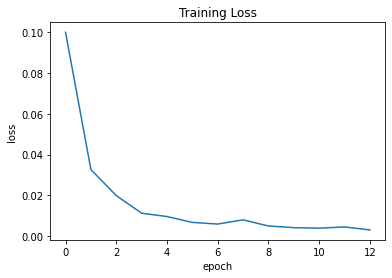

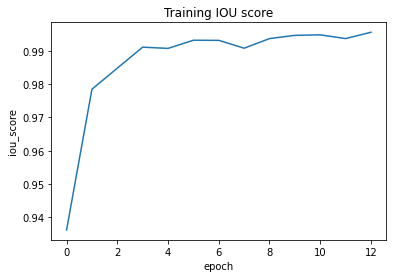

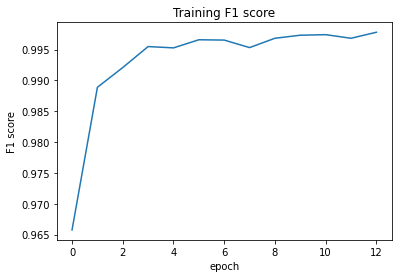

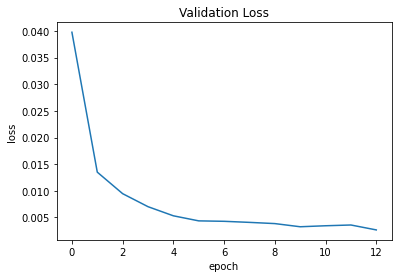

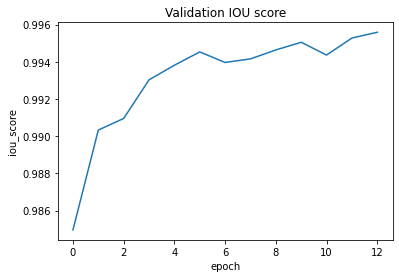

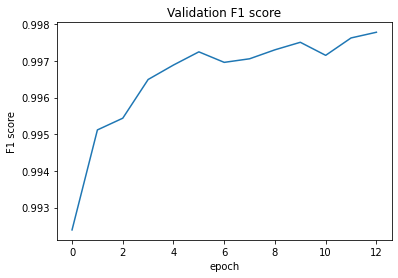

In [25]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["iou_score"])
plt.title("Training IOU score")
plt.ylabel("iou_score")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["f1-score"])
plt.title("Training F1 score")
plt.ylabel("F1 score")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_iou_score"])
plt.title("Validation IOU score")
plt.ylabel("iou_score")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_f1-score"])
plt.title("Validation F1 score")
plt.ylabel("F1 score")
plt.xlabel("epoch")
plt.show()

In [26]:
model.save("log_sem_seg_model.h5")